In [1]:
!pip install xlrd

In [2]:
!pip install openpyxl

import pathlib

import pandas as pd
import numpy as np
import xlrd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import scipy.stats as stats
import tensorflow as tf

In [3]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install bayesian-optimization

In [5]:
PY_DATOS_REALES_EST_SA=pd.read_excel("/content/drive/MyDrive/Datos/Copia de 4 Variables. Datos reales estandarizados sin atípicos (z-score).xlsx", sheet_name='Datos sin atipicos', header=0, index_col=0, usecols='A, B, C, D, E')
PY_DATOS_REALES_EST_SA

,Días,Área,PY_VC_PCA,Valor_Proyecto
#,,,,
1,0.199969,-0.224328,-0.670771,-0.563421
2,0.199969,-0.224328,-0.670771,-0.545120
3,0.199969,-0.222966,-0.670771,-0.544601
4,0.199969,-0.222966,-0.670771,-0.532932
5,1.478731,-0.182279,-0.670771,-0.532623
...,...,...,...,...
121,-0.699160,-0.219754,-1.883419,-0.617652
122,-0.659199,-0.223679,-1.883419,-0.604545
123,-0.579276,-0.224410,-1.883419,-0.584883


In [6]:
PY_DATOS_REALES_EST_SA.describe()

,Días,Área,PY_VC_PCA,Valor_Proyecto
count,115.000000,115.000000,115.000000,115.000000
mean,-0.082193,-0.098454,-0.089025,-0.097465
std,0.780387,0.605987,1.861373,0.706249
min,-0.918948,-0.224417,-1.932311,-0.682176
25%,-0.669189,-0.224096,-1.883419,-0.587202
50%,-0.359489,-0.222363,-0.670771,-0.410561
75%,0.219950,-0.203633,0.739387,0.150954
max,3.576699,4.300396,3.524117,2.571424


In [7]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, ReLU, ELU
from keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad
from keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from bayes_opt import BayesianOptimization
from scipy.stats import spearmanr
import random

# Fijar la semilla para reproducibilidad
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Función personalizada para calcular SSE
def sse(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_true - y_pred))

# Función personalizada para calcular SAE
def sae(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true - y_pred))

# Función personalizada para calcular el coeficiente de determinación R^2
def r2_keras(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

# Función personalizada para calcular el coeficiente de correlación de Pearson
def pearson_correlation(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    x = y_true - tf.reduce_mean(y_true)
    y = y_pred - tf.reduce_mean(y_pred)
    r_num = tf.reduce_sum(x * y)
    r_den = tf.sqrt(tf.reduce_sum(tf.square(x)) * tf.reduce_sum(tf.square(y)))
    return r_num / (r_den + tf.keras.backend.epsilon())

# Función para calcular RMSE
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Seleccionar las columnas relevantes para la predicción de 'Valor_Proyecto'
data = PY_DATOS_REALES_EST_SA[['Días', 'Área', 'PY_VC_PCA', 'Valor_Proyecto']]
X = data.drop('Valor_Proyecto', axis=1).values
y = data['Valor_Proyecto'].values

# Dividir los datos en entrenamiento y validación con una semilla fija
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Función que entrena el modelo y devuelve la pérdida final, el historial y el modelo
def train_model_with_params(units_1, units_2, units_3, units_4, units_5, learning_rate):
    model = Sequential([
        Dense(int(units_1), input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        LeakyReLU(alpha=0.1),  # Cambiar ELU por LeakyReLU
        BatchNormalization(momentum=0.8),

        Dense(int(units_2), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        LeakyReLU(alpha=0.1),  # Cambiar ELU por LeakyReLU
        BatchNormalization(momentum=0.8),

        Dense(int(units_3), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        LeakyReLU(alpha=0.1),  # Cambiar ELU por LeakyReLU
        BatchNormalization(momentum=0.8),

        Dense(int(units_4), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        LeakyReLU(alpha=0.1),  # Cambiar ELU por LeakyReLU
        BatchNormalization(momentum=0.8),

        Dense(int(units_5), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        LeakyReLU(alpha=0.1),  # Cambiar ELU por LeakyReLU
        BatchNormalization(momentum=0.8),

        Dense(1, activation='linear')
    ])

    # Usar Huber como pérdida y agregar Huber Loss como métrica
    model.compile(optimizer=RMSprop(learning_rate),
                  loss=tf.keras.losses.Huber(), #----------------------------
                  metrics=['mae', 'mse', rmse, sse, sae, r2_keras, pearson_correlation, tf.keras.losses.Huber(name='huber_loss')])

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) #----------------50
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=1000,   #---------------1000
                        batch_size=64,
                        callbacks=[early_stopping, reduce_lr, checkpoint],
                        verbose=1)

    return -history.history['val_loss'][-1], history, model

# Función solo para la optimización bayesiana (retorna solo la pérdida)
def train_model_for_optimization(units_1, units_2, units_3, units_4, units_5, learning_rate):

    val_loss, _, _ = train_model_with_params(units_1, units_2, units_3, units_4, units_5, learning_rate)
    return val_loss

# Definir los límites para la optimización
pbounds = {
    'units_1': (5, 100),
    'units_2': (5, 100),
    'units_3': (5, 100),
    'units_4': (5, 100),
    'units_5': (5, 100),
    'learning_rate': (0.0001, 0.01)
}

# Crear una instancia de BayesianOptimization con semilla
optimizer = BayesianOptimization(
    f=train_model_for_optimization,
    pbounds=pbounds,
    random_state=42,  # Fijar la semilla para la optimización bayesiana
    verbose=2
)

# Ejecutar la optimización
optimizer.maximize(init_points=2, n_iter=20) #---------------20

# Recuperar los mejores hiperparámetros
best_params = optimizer.max['params']

# Redondear los valores de las unidades a enteros para las capas
best_params['units_1'] = int(round(best_params['units_1']))
best_params['units_2'] = int(round(best_params['units_2']))
best_params['units_3'] = int(round(best_params['units_3']))
best_params['units_4'] = int(round(best_params['units_4']))
best_params['units_5'] = int(round(best_params['units_5']))

# Imprimir los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Entrenar el modelo con los mejores hiperparámetros encontrados y obtener el historial y el modelo
val_loss, history, model = train_model_with_params(
    best_params['units_1'],
    best_params['units_2'],
    best_params['units_3'],
    best_params['units_4'],
    best_params['units_5'],
    best_params['learning_rate']
)

|   iter    |  target   | learni... |  units_1  |  units_2  |  units_3  |  units_4  |  units_5  |
-------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - huber_loss: 0.8397 - loss: 1.0412 - mae: 1.2113 - mse: 2.9292 - pearson_correlation: -1.6957e-16 - r2_keras: -448.6150 - rmse: 1.8452 - sae: 5384.2646 - sse: 13946.4951
Epoch 1: val_loss improved from inf to 0.40327, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 689ms/step - huber_loss: 0.7523 - loss: 0.9882 - mae: 1.1679 - mse: 2.6134 - pearson_correlation: -8.1453e-17 - r2_keras: -324.3587 - rmse: 1.5876 - sae: 3816.0579 - sse: 9598.1318 - val_huber_loss: 0.1996 - val_loss: 0.4033 - val_mae: 0.5059 - val_mse: 0.5001 - val_pearson_correlation: -8.8223e-17 - val_r2_keras: -23.6741 - val_rmse: 0.8089 - val_sae: 320.4227 - val_sse: 346.1309 - learning_rate: 0.0038
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - huber_loss: 0.3760 - loss: 0.5796 - mae: 0.7180 - mse: 0.8870 - pearson_correlation: 3.3775e-16 - r2_keras: -187.0732 - rmse: 1.1934 - sae: 3833.1853 - sse: 5833.7969
Epoch 2: val_loss did not improve from 0.40

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - huber_loss: 1.3536 - loss: 1.5407 - mae: 1.8180 - mse: 4.6377 - pearson_correlation: 6.5242e-17 - r2_keras: -616.2565 - rmse: 2.1620 - sae: 7580.5361 - sse: 19146.5254
Epoch 1: val_loss improved from inf to 0.42455, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 635ms/step - huber_loss: 1.3172 - loss: 1.5192 - mae: 1.7912 - mse: 4.5418 - pearson_correlation: 3.6264e-17 - r2_keras: -484.0648 - rmse: 2.0471 - sae: 5443.8589 - sse: 13627.2178 - val_huber_loss: 0.2339 - val_loss: 0.4245 - val_mae: 0.5371 - val_mse: 0.5963 - val_pearson_correlation: 2.6889e-16 - val_r2_keras: -22.8719 - val_rmse: 0.7956 - val_sae: 289.9404 - val_sse: 334.8775 - learning_rate: 0.0047
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - huber_loss: 0.3357 - loss: 0.5263 - mae: 0.6810 - mse: 0.8518 - pearson_correlation: -4.1718e-17 - r2_keras: -149.6291 - rmse: 1.0680 - sae: 3297.5710 - sse: 4672.3271
Epoch 2: val_loss improved from 0.42455 to 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - huber_loss: 1.0141 - loss: 1.1326 - mae: 1.4734 - mse: 3.1700 - pearson_correlation: 1.9596e-16 - r2_keras: -284.9043 - rmse: 1.4714 - sae: 4933.6260 - sse: 8868.3926
Epoch 1: val_loss improved from inf to 0.36085, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 620ms/step - huber_loss: 0.8191 - loss: 1.0139 - mae: 1.3305 - mse: 2.7434 - pearson_correlation: 7.6905e-17 - r2_keras: -213.2246 - rmse: 1.3242 - sae: 3503.5842 - sse: 6189.3462 - val_huber_loss: 0.2423 - val_loss: 0.3609 - val_mae: 0.5937 - val_mse: 0.5885 - val_pearson_correlation: -4.6844e-17 - val_r2_keras: -22.2623 - val_rmse: 0.7854 - val_sae: 321.6080 - val_sse: 326.3254 - learning_rate: 4.2145e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.5563 - loss: 0.6748 - mae: 0.9283 - mse: 1.4814 - pearson_correlation: 3.2946e-16 - r2_keras: -172.5651 - rmse: 1.1465 - sae: 3904.7751 - sse: 5383.7715
Epoch 2: val_loss improved from 0.36085 to 0.34683, sav

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - huber_loss: 0.8321 - loss: 1.0846 - mae: 1.2541 - mse: 3.0748 - pearson_correlation: 1.1337e-16 - r2_keras: -320.7417 - rmse: 1.5609 - sae: 4727.8628 - sse: 9980.0254
Epoch 1: val_loss improved from inf to 1.01836, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 643ms/step - huber_loss: 1.5449 - loss: 1.5201 - mae: 1.6879 - mse: 7.3020 - pearson_correlation: -1.7750e-16 - r2_keras: -817.9007 - rmse: 2.7768 - sae: 4103.7227 - sse: 13743.0566 - val_huber_loss: 0.7546 - val_loss: 1.0184 - val_mae: 1.2206 - val_mse: 2.0576 - val_pearson_correlation: -3.5014e-16 - val_r2_keras: -49.4196 - val_rmse: 1.1563 - val_sae: 512.1649 - val_sse: 707.2919 - learning_rate: 0.0072
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - huber_loss: 2.1891 - loss: 2.4528 - mae: 2.6423 - mse: 10.7289 - pearson_correlation: 3.0647e-17 - r2_keras: -1230.2533 - rmse: 3.0536 - sae: 10237.8359 - sse: 38191.9375
Epoch 2: val_loss improved from 1.01836 to 0.64008, s

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - huber_loss: 1.5489 - loss: 1.7069 - mae: 2.0148 - mse: 5.5041 - pearson_correlation: 1.0157e-16 - r2_keras: -551.5088 - rmse: 2.0455 - sae: 6928.8887 - sse: 17138.1309
Epoch 1: val_loss improved from inf to 0.40446, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 675ms/step - huber_loss: 1.1972 - loss: 1.4929 - mae: 1.7745 - mse: 4.6246 - pearson_correlation: 1.3770e-16 - r2_keras: -394.1633 - rmse: 1.7294 - sae: 4843.3652 - sse: 11740.0693 - val_huber_loss: 0.2463 - val_loss: 0.4045 - val_mae: 0.6063 - val_mse: 0.5928 - val_pearson_correlation: -2.6080e-16 - val_r2_keras: -22.2486 - val_rmse: 0.7852 - val_sae: 326.7879 - val_sse: 326.1334 - learning_rate: 0.0017
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - huber_loss: 0.2532 - loss: 0.4114 - mae: 0.5721 - mse: 0.6031 - pearson_correlation: -5.7847e-17 - r2_keras: -121.0131 - rmse: 0.9612 - sae: 3080.8491 - sse: 3784.6951
Epoch 2: val_loss improved from 0.40446 to 0.40324, savi

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - huber_loss: 0.8588 - loss: 1.0663 - mae: 1.2601 - mse: 2.8956 - pearson_correlation: -5.7335e-16 - r2_keras: -376.5990 - rmse: 1.6910 - sae: 5212.8901 - sse: 11712.6475
Epoch 1: val_loss improved from inf to 0.48433, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 642ms/step - huber_loss: 0.7222 - loss: 0.9833 - mae: 1.1738 - mse: 2.5535 - pearson_correlation: -2.0148e-16 - r2_keras: -293.6430 - rmse: 1.5900 - sae: 3750.8171 - sse: 8311.7715 - val_huber_loss: 0.2758 - val_loss: 0.4843 - val_mae: 0.6449 - val_mse: 0.6455 - val_pearson_correlation: 6.4580e-17 - val_r2_keras: -23.9553 - val_rmse: 0.8135 - val_sae: 343.7079 - val_sse: 350.0755 - learning_rate: 0.0025
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.5464 - loss: 0.7550 - mae: 0.9862 - mse: 1.5087 - pearson_correlation: 4.2751e-17 - r2_keras: -262.7267 - rmse: 1.4132 - sae: 4348.4238 - sse: 8180.4731
Epoch 2: val_loss improved from 0.48433 to 0.40668, savin

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - huber_loss: 0.5329 - loss: 0.6798 - mae: 0.8432 - mse: 1.8718 - pearson_correlation: 2.8404e-16 - r2_keras: -341.5961 - rmse: 1.6107 - sae: 4366.6460 - sse: 10626.9033
Epoch 1: val_loss improved from inf to 0.39906, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 631ms/step - huber_loss: 0.5927 - loss: 0.7161 - mae: 0.8999 - mse: 1.8952 - pearson_correlation: 3.1717e-16 - r2_keras: -267.8101 - rmse: 1.5228 - sae: 3177.2429 - sse: 7558.6450 - val_huber_loss: 0.2522 - val_loss: 0.3991 - val_mae: 0.5914 - val_mse: 0.6260 - val_pearson_correlation: 2.4511e-16 - val_r2_keras: -22.0338 - val_rmse: 0.7815 - val_sae: 310.7322 - val_sse: 323.1208 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - huber_loss: 0.4495 - loss: 0.5964 - mae: 0.7306 - mse: 1.5505 - pearson_correlation: 2.7438e-17 - r2_keras: -289.9942 - rmse: 1.4845 - sae: 3906.3757 - sse: 9026.2754
Epoch 2: val_loss did not improve from 0.39906
2/2 ━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - huber_loss: 0.5655 - loss: 0.7619 - mae: 0.9408 - mse: 1.6296 - pearson_correlation: 2.1324e-16 - r2_keras: -326.7546 - rmse: 1.5755 - sae: 4946.1709 - sse: 10166.5381
Epoch 1: val_loss improved from inf to 0.44097, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 667ms/step - huber_loss: 0.5051 - loss: 0.7253 - mae: 0.8937 - mse: 1.5329 - pearson_correlation: -1.8514e-17 - r2_keras: -248.0252 - rmse: 1.4405 - sae: 3505.6404 - sse: 7135.7173 - val_huber_loss: 0.2440 - val_loss: 0.4410 - val_mae: 0.5484 - val_mse: 0.6256 - val_pearson_correlation: -6.9844e-17 - val_r2_keras: -22.9622 - val_rmse: 0.7971 - val_sae: 301.5199 - val_sse: 336.1450 - learning_rate: 0.0023
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.4990 - loss: 0.6960 - mae: 0.8782 - mse: 1.3630 - pearson_correlation: 3.4076e-17 - r2_keras: -245.7121 - rmse: 1.3669 - sae: 4221.2920 - sse: 7652.7017
Epoch 2: val_loss improved from 0.44097 to 0.40701, savin

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - huber_loss: 0.5361 - loss: 0.7186 - mae: 0.9044 - mse: 1.3713 - pearson_correlation: -8.9540e-17 - r2_keras: -157.7369 - rmse: 1.0964 - sae: 3472.2759 - sse: 4923.8208
Epoch 1: val_loss improved from inf to 0.42888, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 651ms/step - huber_loss: 0.4138 - loss: 0.6447 - mae: 0.8089 - mse: 1.1661 - pearson_correlation: 5.3336e-17 - r2_keras: -122.8005 - rmse: 1.0304 - sae: 2492.0256 - sse: 3493.4050 - val_huber_loss: 0.2435 - val_loss: 0.4289 - val_mae: 0.5197 - val_mse: 0.6398 - val_pearson_correlation: 1.5333e-16 - val_r2_keras: -23.5426 - val_rmse: 0.8067 - val_sae: 277.5978 - val_sse: 344.2867 - learning_rate: 0.0045
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.4939 - loss: 0.6793 - mae: 0.8101 - mse: 1.8823 - pearson_correlation: 1.0868e-17 - r2_keras: -328.7353 - rmse: 1.5802 - sae: 4314.7852 - sse: 10227.9766
Epoch 2: val_loss improved from 0.42888 to 0.41367, saving

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - huber_loss: 1.3710 - loss: 1.5339 - mae: 1.8065 - mse: 4.5961 - pearson_correlation: -1.7612e-16 - r2_keras: -594.1541 - rmse: 2.1230 - sae: 7605.7993 - sse: 18460.9355
Epoch 1: val_loss improved from inf to 0.41672, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 651ms/step - huber_loss: 1.2453 - loss: 1.4575 - mae: 1.7355 - mse: 4.2642 - pearson_correlation: -1.2326e-16 - r2_keras: -449.2741 - rmse: 1.9319 - sae: 5415.9829 - sse: 12934.9023 - val_huber_loss: 0.2529 - val_loss: 0.4167 - val_mae: 0.6054 - val_mse: 0.6218 - val_pearson_correlation: -1.6570e-17 - val_r2_keras: -22.0614 - val_rmse: 0.7820 - val_sae: 318.1536 - val_sse: 323.5082 - learning_rate: 0.0028
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - huber_loss: 0.2348 - loss: 0.3987 - mae: 0.5482 - mse: 0.5919 - pearson_correlation: 8.2669e-17 - r2_keras: -87.5293 - rmse: 0.8188 - sae: 2577.4800 - sse: 2746.0696
Epoch 2: val_loss improved from 0.41672 to 0.40472, savi

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - huber_loss: 1.4135 - loss: 1.5614 - mae: 1.8797 - mse: 5.4707 - pearson_correlation: 5.9795e-17 - r2_keras: -684.2451 - rmse: 2.2780 - sae: 7087.1523 - sse: 21255.4453
Epoch 1: val_loss improved from inf to 0.40348, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 622ms/step - huber_loss: 1.3521 - loss: 1.5241 - mae: 1.8358 - mse: 5.1815 - pearson_correlation: -2.6601e-18 - r2_keras: -551.6478 - rmse: 2.2100 - sae: 5151.2622 - sse: 15294.2432 - val_huber_loss: 0.2556 - val_loss: 0.4035 - val_mae: 0.6215 - val_mse: 0.6093 - val_pearson_correlation: 0.0000e+00 - val_r2_keras: -22.4201 - val_rmse: 0.7881 - val_sae: 330.4576 - val_sse: 328.5403 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - huber_loss: 1.1403 - loss: 1.2882 - mae: 1.5892 - mse: 4.0315 - pearson_correlation: -2.0064e-17 - r2_keras: -511.6166 - rmse: 1.9703 - sae: 6117.1289 - sse: 15900.7246
Epoch 2: val_loss did not improve from 0.40348
2/2 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - huber_loss: 0.5391 - loss: 0.7038 - mae: 0.9279 - mse: 1.2716 - pearson_correlation: -1.8351e-16 - r2_keras: -192.4606 - rmse: 1.2104 - sae: 3927.1758 - sse: 6000.9048
Epoch 1: val_loss improved from inf to 0.42068, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 617ms/step - huber_loss: 0.5360 - loss: 0.7019 - mae: 0.9258 - mse: 1.3046 - pearson_correlation: -1.2435e-16 - r2_keras: -160.3091 - rmse: 1.2085 - sae: 2841.5745 - sse: 4379.8979 - val_huber_loss: 0.2561 - val_loss: 0.4207 - val_mae: 0.6112 - val_mse: 0.6242 - val_pearson_correlation: 2.5312e-16 - val_r2_keras: -22.1296 - val_rmse: 0.7832 - val_sae: 321.5070 - val_sse: 324.4649 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - huber_loss: 0.3371 - loss: 0.5017 - mae: 0.7044 - mse: 0.7394 - pearson_correlation: -4.7841e-16 - r2_keras: -153.0324 - rmse: 1.0800 - sae: 3500.7969 - sse: 4777.8911
Epoch 2: val_loss did not improve from 0.42068
2/2 ━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - huber_loss: 0.6095 - loss: 0.7628 - mae: 1.0286 - mse: 1.5302 - pearson_correlation: -1.8495e-16 - r2_keras: -163.4859 - rmse: 1.1161 - sae: 3619.6426 - sse: 5102.1470
Epoch 1: val_loss improved from inf to 0.38666, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 614ms/step - huber_loss: 0.5165 - loss: 0.7063 - mae: 0.9589 - mse: 1.3723 - pearson_correlation: 1.3461e-17 - r2_keras: -133.0207 - rmse: 1.0926 - sae: 2626.6013 - sse: 3687.2148 - val_huber_loss: 0.2328 - val_loss: 0.3867 - val_mae: 0.5538 - val_mse: 0.5890 - val_pearson_correlation: -2.7343e-16 - val_r2_keras: -22.1434 - val_rmse: 0.7834 - val_sae: 300.7124 - val_sse: 324.6584 - learning_rate: 0.0024
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - huber_loss: 0.2955 - loss: 0.4493 - mae: 0.6165 - mse: 0.7080 - pearson_correlation: -1.9656e-16 - r2_keras: -95.2550 - rmse: 0.8538 - sae: 2725.9817 - sse: 2985.7087
Epoch 2: val_loss improved from 0.38666 to 0.37514, saving

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - huber_loss: 0.4729 - loss: 0.6345 - mae: 0.7895 - mse: 1.2161 - pearson_correlation: 4.0174e-16 - r2_keras: -165.0319 - rmse: 1.1213 - sae: 3306.7075 - sse: 5150.1025
Epoch 1: val_loss improved from inf to 0.40658, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 617ms/step - huber_loss: 0.4029 - loss: 0.5919 - mae: 0.7457 - mse: 1.0898 - pearson_correlation: 2.7533e-16 - r2_keras: -125.6512 - rmse: 1.0297 - sae: 2373.1118 - sse: 3620.6509 - val_huber_loss: 0.2444 - val_loss: 0.4066 - val_mae: 0.5722 - val_mse: 0.6157 - val_pearson_correlation: 1.0222e-16 - val_r2_keras: -22.0650 - val_rmse: 0.7821 - val_sae: 303.7667 - val_sse: 323.5579 - learning_rate: 0.0029
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - huber_loss: 0.6205 - loss: 0.7827 - mae: 1.0187 - mse: 1.5320 - pearson_correlation: 1.1951e-16 - r2_keras: -185.9100 - rmse: 1.1897 - sae: 3790.0405 - sse: 5797.7139
Epoch 2: val_loss improved from 0.40658 to 0.40543, saving m

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - huber_loss: 0.5345 - loss: 0.6910 - mae: 0.8987 - mse: 1.5695 - pearson_correlation: 3.0241e-16 - r2_keras: -259.9780 - rmse: 1.4058 - sae: 4286.9424 - sse: 8095.2124
Epoch 1: val_loss improved from inf to 0.38436, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 622ms/step - huber_loss: 0.8558 - loss: 0.8884 - mae: 1.1139 - mse: 2.2886 - pearson_correlation: 1.5228e-16 - r2_keras: -286.1885 - rmse: 1.6886 - sae: 3363.7354 - sse: 6724.6855 - val_huber_loss: 0.2149 - val_loss: 0.3844 - val_mae: 0.4546 - val_mse: 0.5729 - val_pearson_correlation: -4.8946e-17 - val_r2_keras: -25.0196 - val_rmse: 0.8307 - val_sae: 277.2886 - val_sse: 365.0051 - learning_rate: 0.0100
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - huber_loss: 0.2908 - loss: 0.4603 - mae: 0.6380 - mse: 0.7555 - pearson_correlation: 4.8687e-16 - r2_keras: -184.5204 - rmse: 1.1853 - sae: 3391.6665 - sse: 5754.6094
Epoch 2: val_loss did not improve from 0.38436
2/2 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - huber_loss: 0.6322 - loss: 0.7906 - mae: 1.0441 - mse: 1.7261 - pearson_correlation: 9.6028e-18 - r2_keras: -298.4615 - rmse: 1.5059 - sae: 4854.2988 - sse: 9288.9229
Epoch 1: val_loss improved from inf to 0.39685, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 623ms/step - huber_loss: 0.6455 - loss: 0.7987 - mae: 1.0575 - mse: 1.7078 - pearson_correlation: -1.2269e-17 - r2_keras: -241.8468 - rmse: 1.4681 - sae: 3530.1113 - sse: 6699.4204 - val_huber_loss: 0.2384 - val_loss: 0.3969 - val_mae: 0.5776 - val_mse: 0.5872 - val_pearson_correlation: -6.2255e-17 - val_r2_keras: -22.0968 - val_rmse: 0.7826 - val_sae: 313.1068 - val_sse: 324.0045 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.5363 - loss: 0.6947 - mae: 0.9354 - mse: 1.4296 - pearson_correlation: -1.2011e-16 - r2_keras: -263.6808 - rmse: 1.4158 - sae: 4497.5156 - sse: 8210.0664
Epoch 2: val_loss improved from 0.39685 to 0.38992, s

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - huber_loss: 0.5821 - loss: 0.7413 - mae: 0.9769 - mse: 1.5162 - pearson_correlation: -1.5977e-16 - r2_keras: -230.7220 - rmse: 1.3247 - sae: 4231.2656 - sse: 7187.7271
Epoch 1: val_loss improved from inf to 0.40323, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 624ms/step - huber_loss: 0.6024 - loss: 0.7536 - mae: 0.9847 - mse: 1.5523 - pearson_correlation: -7.9029e-17 - r2_keras: -188.7961 - rmse: 1.3028 - sae: 3070.0801 - sse: 5206.0610 - val_huber_loss: 0.2440 - val_loss: 0.4032 - val_mae: 0.5712 - val_mse: 0.6132 - val_pearson_correlation: 3.8992e-17 - val_r2_keras: -22.1298 - val_rmse: 0.7832 - val_sae: 301.1215 - val_sse: 324.4671 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - huber_loss: 0.3732 - loss: 0.5324 - mae: 0.7169 - mse: 0.9261 - pearson_correlation: -1.6190e-16 - r2_keras: -183.9884 - rmse: 1.1836 - sae: 3586.1904 - sse: 5738.1094
Epoch 2: val_loss did not improve from 0.40323
2/2 ━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - huber_loss: 0.6753 - loss: 0.8347 - mae: 1.0815 - mse: 1.7491 - pearson_correlation: -3.2855e-16 - r2_keras: -197.6797 - rmse: 1.2266 - sae: 4046.8562 - sse: 6162.7964
Epoch 1: val_loss improved from inf to 0.42429, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 619ms/step - huber_loss: 0.6411 - loss: 0.8146 - mae: 1.0662 - mse: 1.6687 - pearson_correlation: -2.0467e-16 - r2_keras: -170.1256 - rmse: 1.2569 - sae: 2972.8843 - sse: 4562.1602 - val_huber_loss: 0.2597 - val_loss: 0.4243 - val_mae: 0.6050 - val_mse: 0.6426 - val_pearson_correlation: 4.8471e-17 - val_r2_keras: -22.1179 - val_rmse: 0.7830 - val_sae: 311.9384 - val_sse: 324.3000 - learning_rate: 0.0063
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - huber_loss: 0.5792 - loss: 0.7438 - mae: 1.0024 - mse: 1.4671 - pearson_correlation: 7.3629e-17 - r2_keras: -183.6967 - rmse: 1.1827 - sae: 3801.0181 - sse: 5729.0615
Epoch 2: val_loss improved from 0.42429 to 0.39330, saving

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - huber_loss: 0.5999 - loss: 0.7702 - mae: 1.0106 - mse: 1.5208 - pearson_correlation: -4.0963e-17 - r2_keras: -235.5647 - rmse: 1.3385 - sae: 4431.6221 - sse: 7337.9404
Epoch 1: val_loss improved from inf to 0.41378, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 621ms/step - huber_loss: 0.5163 - loss: 0.7193 - mae: 0.9494 - mse: 1.3879 - pearson_correlation: -3.1923e-17 - r2_keras: -193.4226 - rmse: 1.3202 - sae: 3226.2307 - sse: 5322.6021 - val_huber_loss: 0.2435 - val_loss: 0.4138 - val_mae: 0.5944 - val_mse: 0.5898 - val_pearson_correlation: -2.2536e-16 - val_r2_keras: -22.1982 - val_rmse: 0.7843 - val_sae: 322.5951 - val_sse: 325.4265 - learning_rate: 2.0531e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.2531 - loss: 0.4234 - mae: 0.5830 - mse: 0.5708 - pearson_correlation: 6.2757e-17 - r2_keras: -145.7644 - rmse: 1.0542 - sae: 3328.8245 - sse: 4552.4492
Epoch 2: val_loss improved from 0.41378 to 0.40269, s

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - huber_loss: 0.7114 - loss: 0.8669 - mae: 1.1185 - mse: 2.1990 - pearson_correlation: 6.2664e-16 - r2_keras: -339.8164 - rmse: 1.6065 - sae: 4729.9395 - sse: 10571.6982
Epoch 1: val_loss improved from inf to 0.42219, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 638ms/step - huber_loss: 0.7232 - loss: 0.8746 - mae: 1.1257 - mse: 2.1686 - pearson_correlation: 5.3021e-16 - r2_keras: -266.5574 - rmse: 1.5196 - sae: 3420.6448 - sse: 7521.0649 - val_huber_loss: 0.2628 - val_loss: 0.4222 - val_mae: 0.5198 - val_mse: 0.7149 - val_pearson_correlation: -3.6840e-16 - val_r2_keras: -25.1732 - val_rmse: 0.8331 - val_sae: 270.9369 - val_sse: 367.1601 - learning_rate: 0.0061
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - huber_loss: 0.2438 - loss: 0.4032 - mae: 0.5267 - mse: 0.5829 - pearson_correlation: -1.5132e-16 - r2_keras: -103.8566 - rmse: 0.8911 - sae: 2511.1150 - sse: 3252.5200
Epoch 2: val_loss improved from 0.42219 to 0.40760, savin

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - huber_loss: 0.7050 - loss: 0.8586 - mae: 1.0861 - mse: 2.2351 - pearson_correlation: -2.1387e-16 - r2_keras: -231.8508 - rmse: 1.3279 - sae: 4284.1963 - sse: 7222.7422
Epoch 1: val_loss improved from inf to 0.38446, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 633ms/step - huber_loss: 0.6661 - loss: 0.8350 - mae: 1.0701 - mse: 2.0881 - pearson_correlation: -1.2642e-16 - r2_keras: -177.5078 - rmse: 1.2260 - sae: 3073.1775 - sse: 5088.1646 - val_huber_loss: 0.2298 - val_loss: 0.3845 - val_mae: 0.5341 - val_mse: 0.5893 - val_pearson_correlation: -1.9606e-16 - val_r2_keras: -22.6276 - val_rmse: 0.7916 - val_sae: 290.3278 - val_sse: 331.4512 - learning_rate: 0.0034
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - huber_loss: 0.2428 - loss: 0.3975 - mae: 0.5523 - mse: 0.6092 - pearson_correlation: 2.8083e-17 - r2_keras: -108.7055 - rmse: 0.9115 - sae: 2829.4299 - sse: 3402.9268
Epoch 2: val_loss did not improve from 0.38446
2/2 ━━━━━━

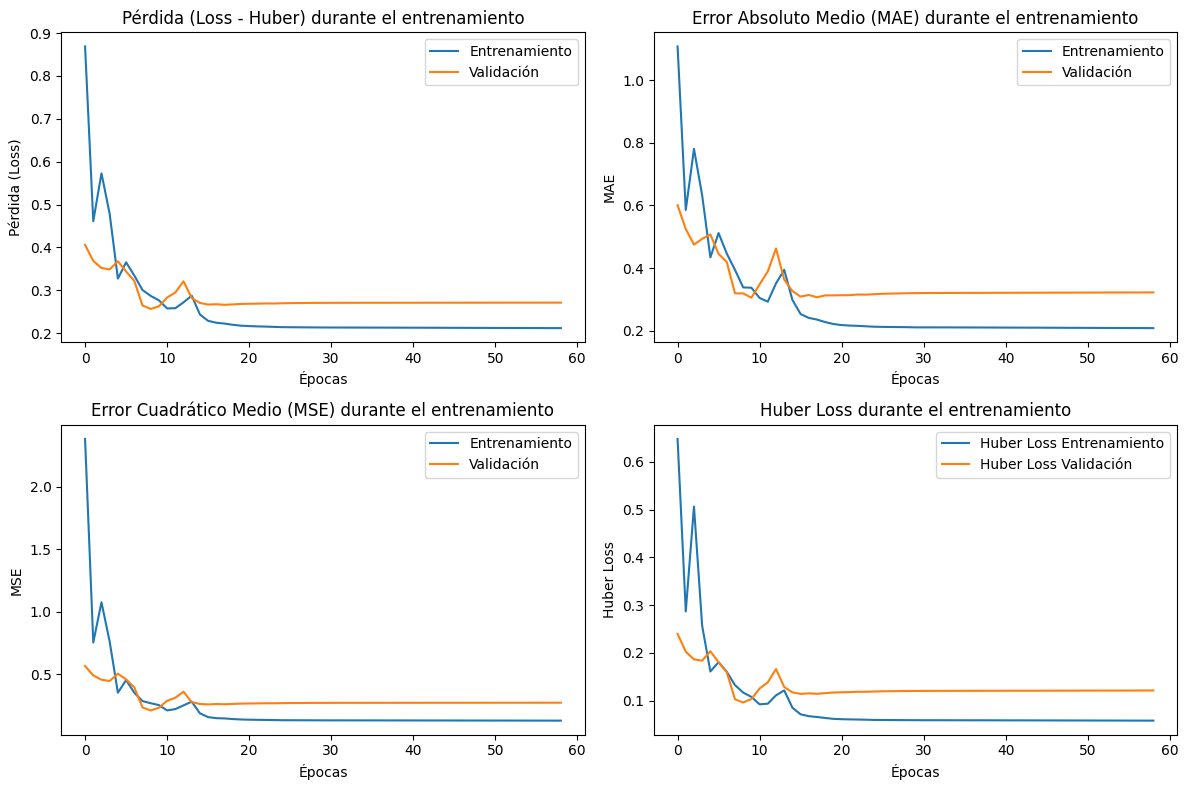

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


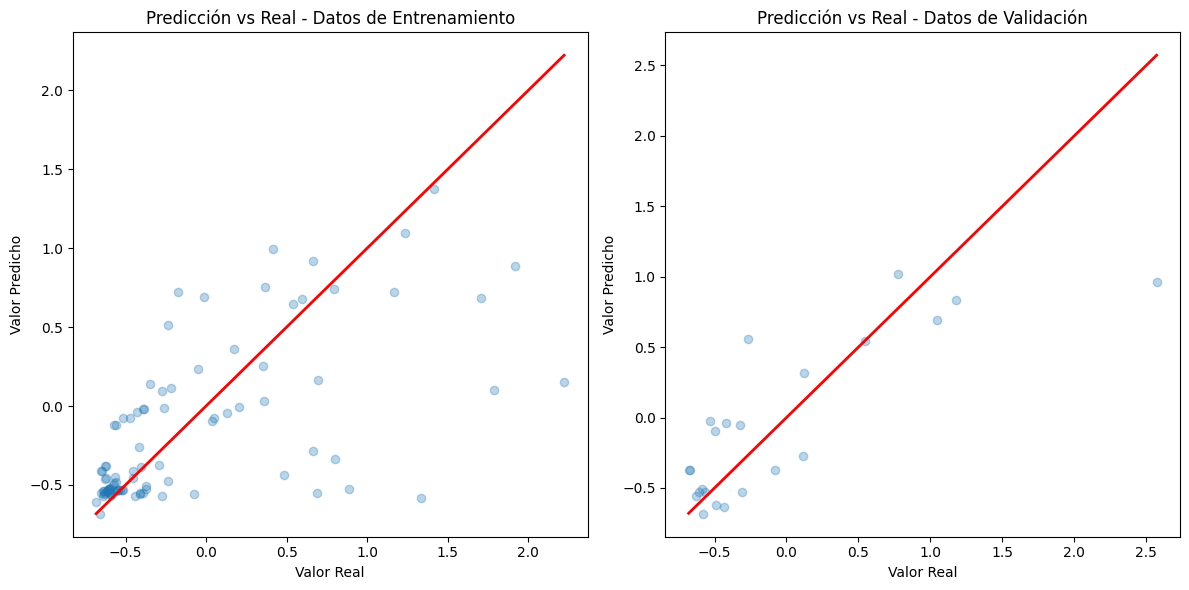


Métricas de entrenamiento:
MSE: 0.276271808996558
RMSE: 0.5256156475948542
MAE: 0.32004665533869747
R^2: 0.4059471779553394
Correlación de Pearson: 2.0190981739074587e-16
Correlación de Spearman: 0.6381994937369364
SSE: 6009.407036164139
SAE: 5074.966400497307
Media del error: 0.06369365491864376
Desviación estándar del error: 0.8402018946241557
Huber Loss (Entrenamiento): 0.05836803466081619

Métricas de validación:
MSE: 0.20862554135729314
RMSE: 0.4567554502765053
MAE: 0.31942150631276056
R^2: 0.6579447607302339
Correlación de Pearson: -1.4611895041535894e-16
Correlación de Spearman: 0.7045454545454546
SSE: 482.6116491930593
SAE: 365.322645639691
Media del error: -0.0013588105233351868
Desviación estándar del error: 0.955147899221077
Huber Loss (Validación): 0.12143297493457794
El punto de convergencia (mejor epoch): 9


In [9]:
# Graficar las curvas de aprendizaje (entrenamiento y validación)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss - Huber) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Validación')
plt.title('Error Absoluto Medio (MAE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['mse'], label='Entrenamiento')
plt.plot(history.history['val_mse'], label='Validación')
plt.title('Error Cuadrático Medio (MSE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['huber_loss'], label='Huber Loss Entrenamiento')
plt.plot(history.history['val_huber_loss'], label='Huber Loss Validación')
plt.title('Huber Loss durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Huber Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar los datos entrenados vs reales y validados vs reales
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

plt.figure(figsize=(12, 6))

# Gráfico de datos de entrenamiento
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', lw=2)
plt.title('Predicción vs Real - Datos de Entrenamiento')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

# Gráfico de datos de validación
plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r', lw=2)
plt.title('Predicción vs Real - Datos de Validación')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.tight_layout()
plt.show()

# Función para calcular la media y desviación estándar
def calcular_media_desviacion(y_true, y_pred):
    diferencia = y_true - y_pred
    media = np.mean(diferencia)
    desviacion = np.std(diferencia)
    return media, desviacion

# Evaluar el modelo final en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)
pearson_train = pearson_correlation(y_train, y_train_pred).numpy()
spearman_train, _ = spearmanr(y_train, y_train_pred)  # Correlación de Spearman
sse_train = np.sum((y_train - y_train_pred) ** 2)
sae_train = np.sum(np.abs(y_train - y_train_pred))
media_train, desviacion_train = calcular_media_desviacion(y_train, y_train_pred)
huber_loss_train = history.history['huber_loss'][-1]

print("\nMétricas de entrenamiento:")
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"MAE: {mae_train}")
print(f"R^2: {r2_train}")
print(f"Correlación de Pearson: {pearson_train}")
print(f"Correlación de Spearman: {spearman_train}")
print(f"SSE: {sse_train}")
print(f"SAE: {sae_train}")
print(f"Media del error: {media_train}")
print(f"Desviación estándar del error: {desviacion_train}")
print(f"Huber Loss (Entrenamiento): {huber_loss_train}")

# Evaluar el modelo final en el conjunto de validación
mse_val = mean_squared_error(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)
pearson_val = pearson_correlation(y_val, y_val_pred).numpy()
spearman_val, _ = spearmanr(y_val, y_val_pred)  # Correlación de Spearman
sse_val = np.sum((y_val - y_val_pred) ** 2)
sae_val = np.sum(np.abs(y_val - y_val_pred))
media_val, desviacion_val = calcular_media_desviacion(y_val, y_val_pred)
huber_loss_val = history.history['val_huber_loss'][-1]

print("\nMétricas de validación:")
print(f"MSE: {mse_val}")
print(f"RMSE: {rmse_val}")
print(f"MAE: {mae_val}")
print(f"R^2: {r2_val}")
print(f"Correlación de Pearson: {pearson_val}")
print(f"Correlación de Spearman: {spearman_val}")
print(f"SSE: {sse_val}")
print(f"SAE: {sae_val}")
print(f"Media del error: {media_val}")
print(f"Desviación estándar del error: {desviacion_val}")
print(f"Huber Loss (Validación): {huber_loss_val}")

# Imprimir la época en la que se alcanzó la mejor validación
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"El punto de convergencia (mejor epoch): {best_epoch}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


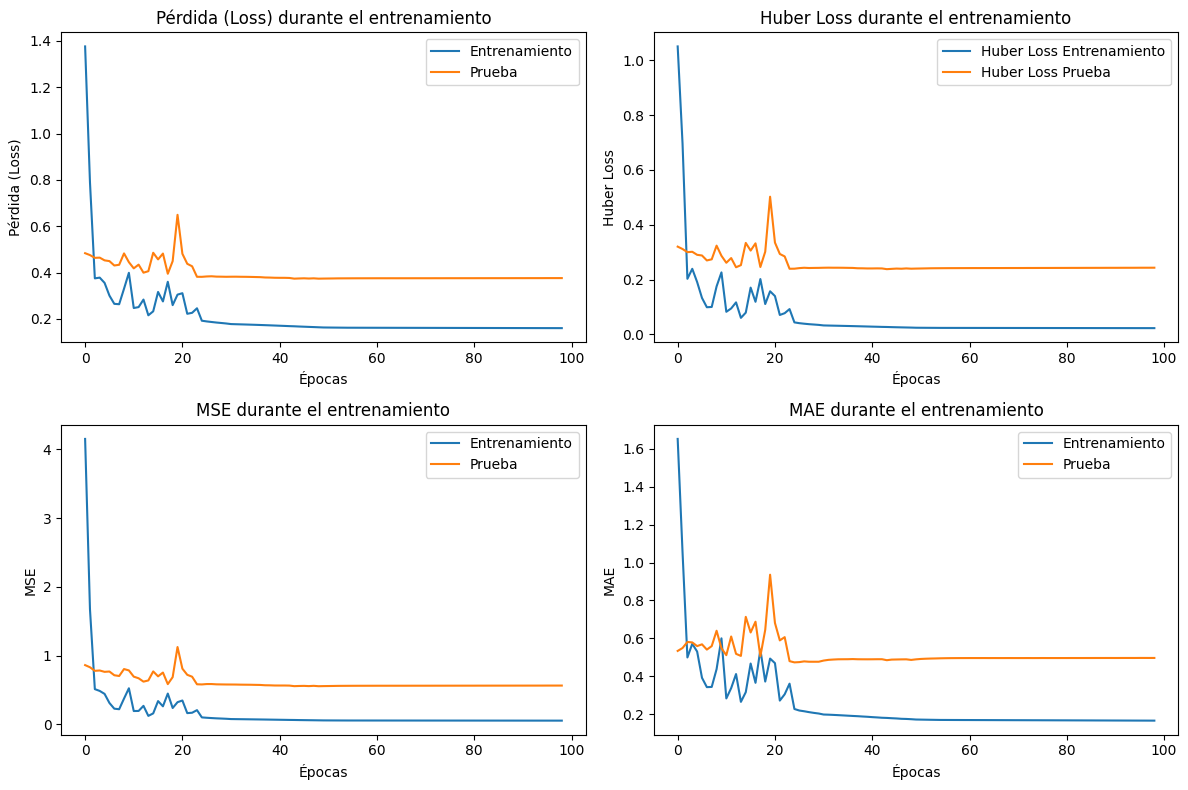

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


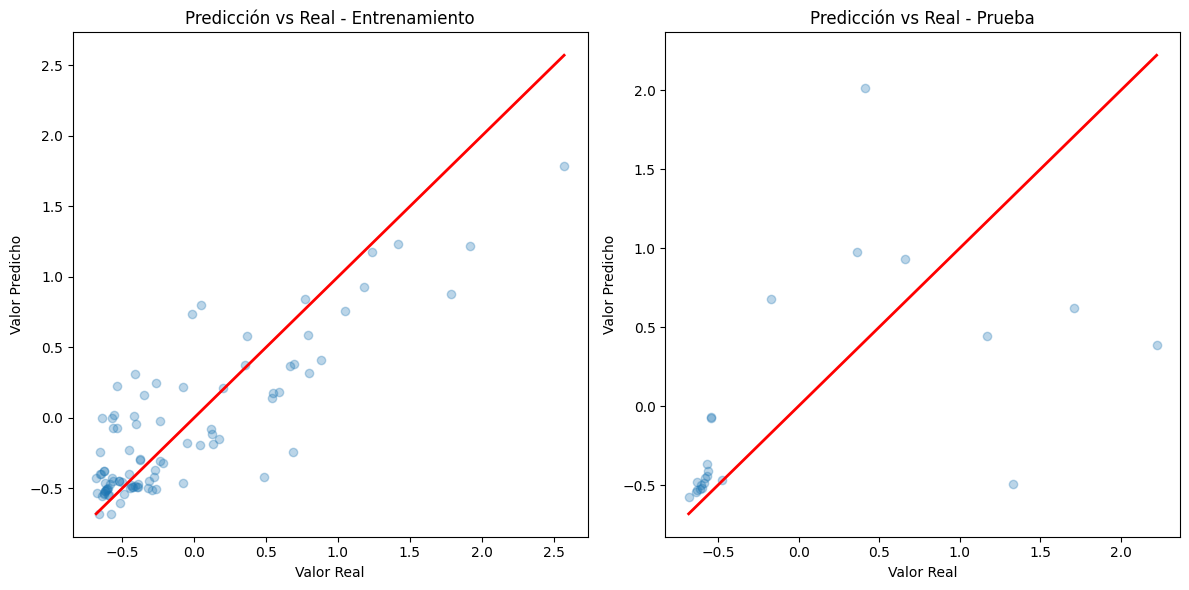

Simulación de cross_val_score (MSE): 0.275037561602259 ± 0.14268626843268664
Simulación de cross_val_score (RMSE): 0.5103283756320647 ± 0.12084084833779203
Simulación de cross_val_score (MAE): 0.3440116113658143 ± 0.08758741996184051
SSE promedio: 425.45546235736504
SAE promedio: 337.41588919230446
R^2 promedio: 0.43829282905267897, Desviación estándar: 0.15417246769653437
Correlación de Pearson promedio: -1.5270764979406993e-18, Desviación estándar: 1.7314304723206964e-16
Correlación de Spearman promedio: 0.7166677981127957, Desviación estándar: 0.04906030101567886
Huber Loss promedio: 0.04743613116443157, Desviación estándar: 0.014852699496122066
El punto de convergencia (mejor epoch): 49


In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
import numpy as np

# Definir el número de pliegues (k) para la validación cruzada
k = 5

# Crear un objeto KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Inicializar listas para almacenar las métricas en cada pliegue
mse_scores = []
mae_scores = []
sse_scores = []
sae_scores = []
r2_scores = []
pearson_scores = []
rmse_scores = []
spearman_scores = []
huber_loss_scores = []

# Iterar sobre los pliegues
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Crear y entrenar el modelo con los datos del pliegue actual
    model = Sequential([
        Dense(int(best_params['units_1']), input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Access units_1 from best_params
        LeakyReLU(alpha=0.1),  # Cambiar ELU por LeakyReLU
        BatchNormalization(momentum=0.8),

        Dense(int(best_params['units_2']), kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Access units_2 from best_params
        LeakyReLU(alpha=0.1),  # Cambiar ELU por LeakyReLU
        BatchNormalization(momentum=0.8),

        Dense(int(best_params['units_3']), kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Access units_3 from best_params
        LeakyReLU(alpha=0.1),  # Cambiar ELU por LeakyReLU
        BatchNormalization(momentum=0.8),

        Dense(int(best_params['units_4']), kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Access units_4 from best_params
        LeakyReLU(alpha=0.1),  # Cambiar ELU por LeakyReLU
        BatchNormalization(momentum=0.8),

        Dense(int(best_params['units_5']), kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Access units_5 from best_params
        LeakyReLU(alpha=0.1),  # Cambiar ELU por LeakyReLU
        BatchNormalization(momentum=0.8),

        Dense(1, activation='linear')
    ])

    # Función personalizada para calcular SSE
    def sse(y_true, y_pred):
        return tf.reduce_sum(tf.square(y_true - y_pred))

    # Función personalizada para calcular SAE
    def sae(y_true, y_pred):
        return tf.reduce_sum(tf.abs(y_true - y_pred))

    # Función personalizada para calcular el coeficiente de determinación R^2
    def r2_keras(y_true, y_pred):
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
        ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
        return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

    # Función personalizada para calcular el coeficiente de correlación de Pearson
    def pearson_correlation(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float64)  # Cast y_true to float64
        y_pred = tf.cast(y_pred, tf.float64)  # Cast y_pred to float64
        x = y_true - tf.reduce_mean(y_true)
        y = y_pred - tf.reduce_mean(y_pred)
        r_num = tf.reduce_sum(x * y)
        r_den = tf.sqrt(tf.reduce_sum(tf.square(x)) * tf.reduce_sum(tf.square(y)))
        return r_num / (r_den + tf.keras.backend.epsilon())

    model.compile(optimizer=RMSprop(best_params['learning_rate']),#------------------------------------
                  loss=tf.keras.losses.Huber(),                      #---------------------
                  metrics=['mae', 'mse', sse, sae, r2_keras, pearson_correlation, tf.keras.losses.Huber(name='huber_loss')])

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) #-----------------------50
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=1000, #--------------------------1000
                        batch_size=64,
                        callbacks=[early_stopping, reduce_lr],
                        verbose=0)

    # Predecir con el modelo en el conjunto de validación
    y_pred = model.predict(X_val)

    # Calcular las métricas de error
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    sse = np.sum((y_val - y_pred) ** 2)
    sae = np.sum(np.abs(y_val - y_pred))
    r2 = r2_score(y_val, y_pred)
    pearson = pearson_correlation(y_val, y_pred).numpy()
    spearman, _ = spearmanr(y_val, y_pred)
    huber_loss = history.history['huber_loss'][-1]

    # Almacenar las métricas en las listas
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    sse_scores.append(sse)
    sae_scores.append(sae)
    r2_scores.append(r2)
    pearson_scores.append(pearson)
    spearman_scores.append(spearman)
    huber_loss_scores.append(huber_loss)

import matplotlib.pyplot as plt

# Graficar las curvas de aprendizaje (pérdida, huber_loss, mse, mae)
plt.figure(figsize=(12, 8))

# Pérdida (Loss)
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Prueba')
plt.title('Pérdida (Loss) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()

# Huber Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['huber_loss'], label='Huber Loss Entrenamiento')
plt.plot(history.history['val_huber_loss'], label='Huber Loss Prueba')
plt.title('Huber Loss durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Huber Loss')
plt.legend()

# MSE
plt.subplot(2, 2, 3)
plt.plot(history.history['mse'], label='Entrenamiento')
plt.plot(history.history['val_mse'], label='Prueba')
plt.title('MSE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

# MAE
plt.subplot(2, 2, 4)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Prueba')
plt.title('MAE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Gráfico de predicciones en los datos de entrenamiento
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', lw=2)
plt.title('Predicción vs Real - Entrenamiento')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r', lw=2)
plt.title('Predicción vs Real - Prueba')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.tight_layout()
plt.show()

# Calcular estadísticas de las métricas
mse_mean = np.mean(mse_scores)
mse_std = np.std(mse_scores)
rmse_mean = np.mean(rmse_scores)
rmse_std = np.std(rmse_scores)
mae_mean = np.mean(mae_scores)
mae_std = np.std(mae_scores)
sse_mean = np.mean(sse_scores)
sae_mean = np.mean(sae_scores)
r2_mean = np.mean(r2_scores)
r2_std = np.std(r2_scores)
pearson_mean = np.mean(pearson_scores)
pearson_std = np.std(pearson_scores)
spearman_mean = np.mean(spearman_scores)
spearman_std = np.std(spearman_scores)
huber_loss_mean = np.mean(huber_loss_scores)
huber_loss_std = np.std(huber_loss_scores)

# Simular cross_val_score al imprimir el promedio de las métricas
print(f"Simulación de cross_val_score (MSE): {mse_mean} ± {mse_std}")
print(f"Simulación de cross_val_score (RMSE): {rmse_mean} ± {rmse_std}")
print(f"Simulación de cross_val_score (MAE): {mae_mean} ± {mae_std}")
print(f"SSE promedio: {sse_mean}")
print(f"SAE promedio: {sae_mean}")
print(f"R^2 promedio: {r2_mean}, Desviación estándar: {r2_std}")
print(f"Correlación de Pearson promedio: {pearson_mean}, Desviación estándar: {pearson_std}")
print(f"Correlación de Spearman promedio: {spearman_mean}, Desviación estándar: {spearman_std}")
print(f"Huber Loss promedio: {huber_loss_mean}, Desviación estándar: {huber_loss_std}")

# Imprimir la época en la que se alcanzó la mejor validación
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"El punto de convergencia (mejor epoch): {best_epoch}")